In [1]:
import torch
import numpy as np
import pandas as pd
from segregation.local import MultiLocalDiversity, MultiLocalEntropy

# visualization
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

# sbi
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
from sbi.utils.get_nn_models import posterior_nn
from sbi.inference import (SNPE, SNLE, SNRE, 
                           prepare_for_sbi, 
                           simulate_for_sbi,
                           SMCABC)

# schelling
from model import Schelling

/home/eric/.local/share/virtualenvs/compassproject-_5IOlIuy/lib/python3.9/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [2]:
def simulator(par_values):
    pars={
    'width':80, 
    'height':80, 
    'density':0.9,
    'max_steps':100, 
    'mode':'Heterogeneous',
    'minority_pc':0.5, 
    'window_size':30, 
    'conv_threshold':0.01,
    'radius':1, 
    'torus':True,
    'move_fraction':0.15,
    'filename':'test.npz',
    'std1':0,
    'std2':0
    }

    pars['mu1'], pars['mu2'] = par_values
#     pars['mu1'], pars['std1'], pars['mu2'], pars['std2'] = par_values
    model = Schelling(pars)
    model.simulate()
    compositions = model.calc_neighbourhood_compositions(n=8)
    groups = ['group' + str(i) for i in range(2)]
    frame = pd.DataFrame(compositions, columns=groups)
    contributions = MultiLocalEntropy(data=frame, groups=groups).statistics
    return torch.as_tensor(sorted(contributions))
#     return torch.as_tensor([model.avg_fraction_sim])

In [3]:
true_mu1, true_std1, true_mu2, true_std2 = .3, 0, .4, 0
observation = simulator([true_mu1, true_mu2])
observation

tensor([0.5086, 0.5159, 0.5197, 0.6162, 0.6226, 0.6700, 0.7608, 0.7608, 0.7772,
        0.8179, 0.8179, 0.8366, 0.8384, 0.8404, 0.8564, 0.8600, 0.8663, 0.8727,
        0.8752, 0.8774, 0.8832, 0.8832, 0.8890, 0.8905, 0.8936, 0.9121, 0.9183,
        0.9183, 0.9238, 0.9288, 0.9294, 0.9294, 0.9383, 0.9544, 0.9576, 0.9621,
        0.9621, 0.9647, 0.9647, 0.9670, 0.9687, 0.9689, 0.9748, 0.9748, 0.9764,
        0.9831, 0.9842, 0.9852, 0.9852, 0.9891, 0.9917, 0.9928, 0.9951, 0.9963,
        0.9977, 0.9980, 0.9981, 0.9991, 0.9991, 0.9991, 0.9997, 0.9998, 0.9998,
        1.0000], dtype=torch.float64)

In [12]:
prior = utils.BoxUniform(low=[0]*2, high=[1]*2)
posteriors = []
proposal = prior
num_simulations = [2000, 2000, 2000]

sbi_simulator, prior = prepare_for_sbi(simulator, prior)
inference = SNRE(prior=prior)

for number in num_simulations:
    theta, x = simulate_for_sbi(sbi_simulator, proposal, 
                                num_simulations=number, 
                                num_workers=40,
                                simulation_batch_size=1)
    density_estimator = inference.append_simulations(theta, x, 
#                                                      proposal=proposal
                                                    ).train()
    method = 'vi'
    posterior = inference.build_posterior(density_estimator,
                                         sample_with=method,
#                                          vi_parameters=None,
#                                          mcmc_parameters={'num_workers':6, 'thin':5}
                                         )
    
    if method=='vi':
        posterior.set_default_x(observation)
        posterior.train()

    posteriors.append(posterior)
    proposal = posterior.set_default_x(observation)

Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

 Neural network successfully converged after 57 epochs.

  0%|          | 0/2000 [00:00<?, ?it/s]


Converged with loss: -13.05
Quality Score: 0.088 	 Good: Smaller than 0.5  Bad: Larger than 1.0 	         NOTE: Less sensitive to mode collapse.


Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

 Neural network successfully converged after 47 epochs.

  0%|          | 0/2000 [00:00<?, ?it/s]


Converged with loss: -12.48
Quality Score: -0.101 	 Good: Smaller than 0.5  Bad: Larger than 1.0 	         NOTE: Less sensitive to mode collapse.


Running 2000 simulations in 2000 batches.:   0%|          | 0/2000 [00:00<?, ?it/s]

 Neural network successfully converged after 78 epochs.

  0%|          | 0/2000 [00:00<?, ?it/s]


Converged with loss: -15.15
Quality Score: 0.215 	 Good: Smaller than 0.5  Bad: Larger than 1.0 	         NOTE: Less sensitive to mode collapse.


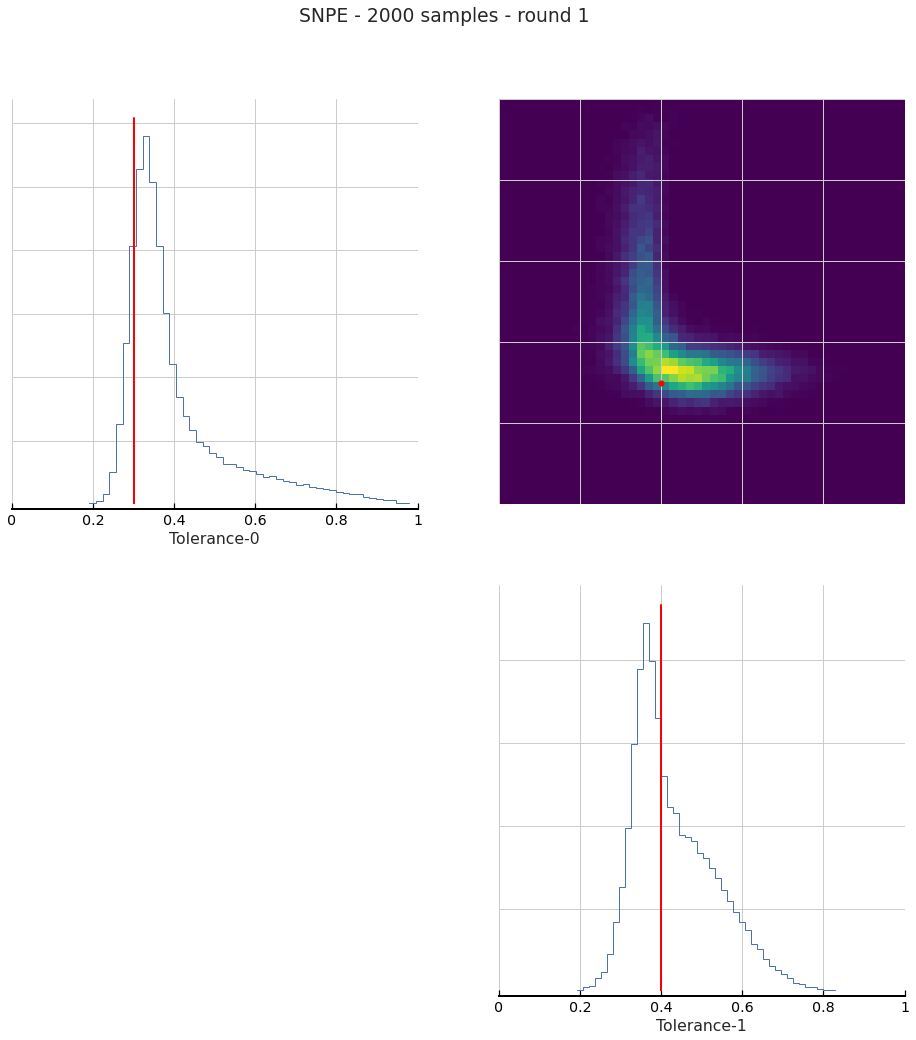

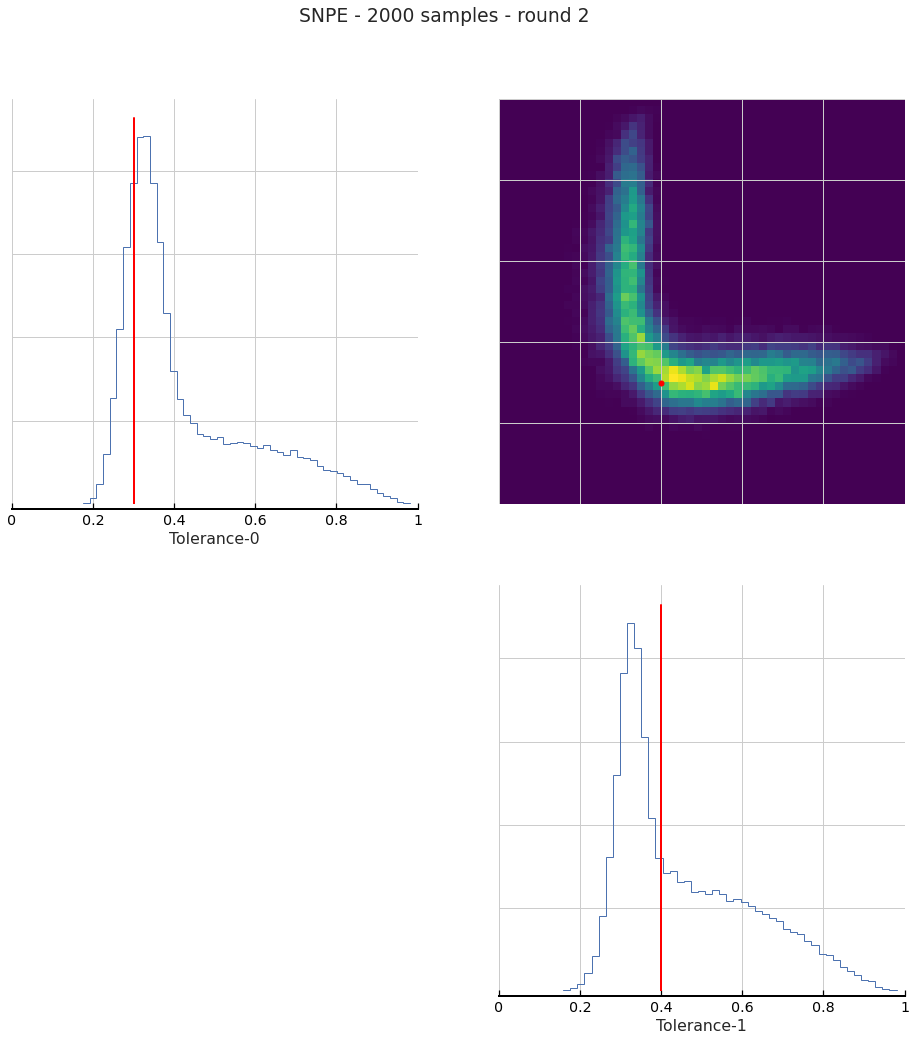

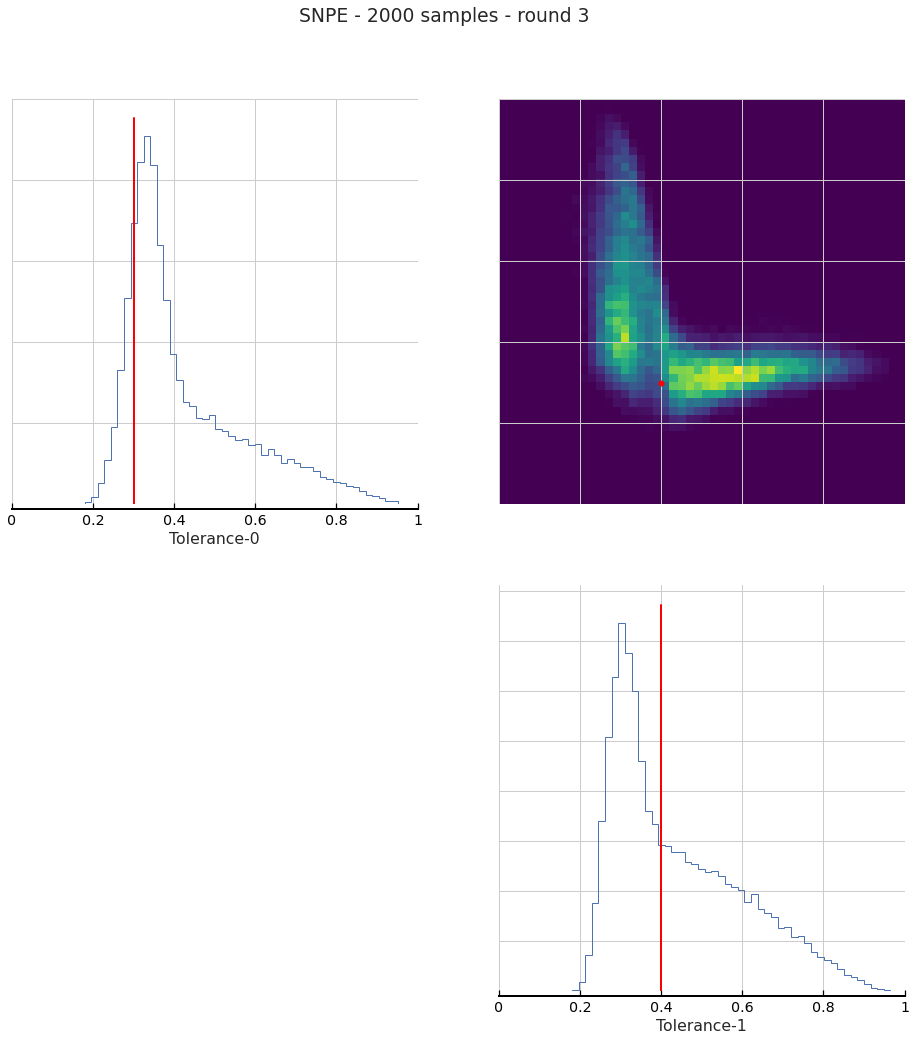

In [14]:
import seaborn as sns
import matplotlib as mpl

sns.set(style="whitegrid", font_scale=1.3)
plt.style.use('paper.mplstyle.txt')
mpl.rc('image', cmap='viridis')

names = ['Tolerance']#, 'Stdev.']

calibration_dict = {'Tolerance':{'names':[f"Tolerance-{i}" for i in range(2)],
                                       'limits':[[0,1],[0,1]],
                                       'true':[true_mu1, true_mu2]
                                        },
#                    'Stdev.':{'names':['Stdev.' + '-' + str(i) for i in range(2)],
#                                        'limits':[[0,1],[0,1]],
#                                        'true':[true_std1, true_std2]
#                                         },
                   }


for i, posterior in enumerate(posteriors):
    
    samples = posterior.sample((50000,), x=observation)
    log_probability = posterior.log_prob(samples, x=observation)
    
    labels, limits, true_values = [], [], []
    for name in names:
        labels += calibration_dict[name]['names']
        limits += calibration_dict[name]['limits']

        
    for j, name in enumerate(names):
        
        true_values = [[0]*j*2 + calibration_dict[name]['true']]

        fig, axes = analysis.pairplot(
            samples,
            subset=[k for k in range(j*2,j*2+2)],
            limits=limits,
            figsize=(16, 16),
            points=true_values,
            points_offdiag={"markersize": 10},
            points_colors=['red']*20,
            labels=labels,
        )
        fig.suptitle('SNPE - ' + str(num_simulations[i]) + ' samples - round ' + str(i+1))